# TMA4320 Biophysics project - Getting started

This short notebook serves as supplementary material to the main project description. It is a prerequisite to have read the this description to understand the symbols used here. 

We will cover how to move monomers on a grid, using functionality you will develop in the first three exercises. **NB!** This means that you must develop these functions on your own, before running this notebook. 

We will also briefly show you how the Python library *numba* works, which is a library that will help you speed up your code considerably. 

In [1]:
# First we import the functions you will develop in 1a), 1b), and 1c)
from secret_vitber_library import generate_grid_of_monomers, visualize_grid, get_neighbors_coordinates

import numpy as np
import matplotlib.pyplot as plt


Let's see how the the functions from the first two exercises work.

In [2]:
grid = generate_grid_of_monomers(N=10, M=10)

[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   9   0]
 [ -7  -1   6   0   0   0   0   0   0   0]
 [ -2   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   3  -5   0   0]
 [  2   0   0   7   0   0   0   0   0   0]
 [  0   0   0   0   0 -10   0   0   0   0]
 [  0   0   0  -3   0   0   0   0  -4   0]
 [  5   8   0   0  -8   0   0   0   0   4]
 [ -9  -6   1   0   0  10   0   0   0   0]]


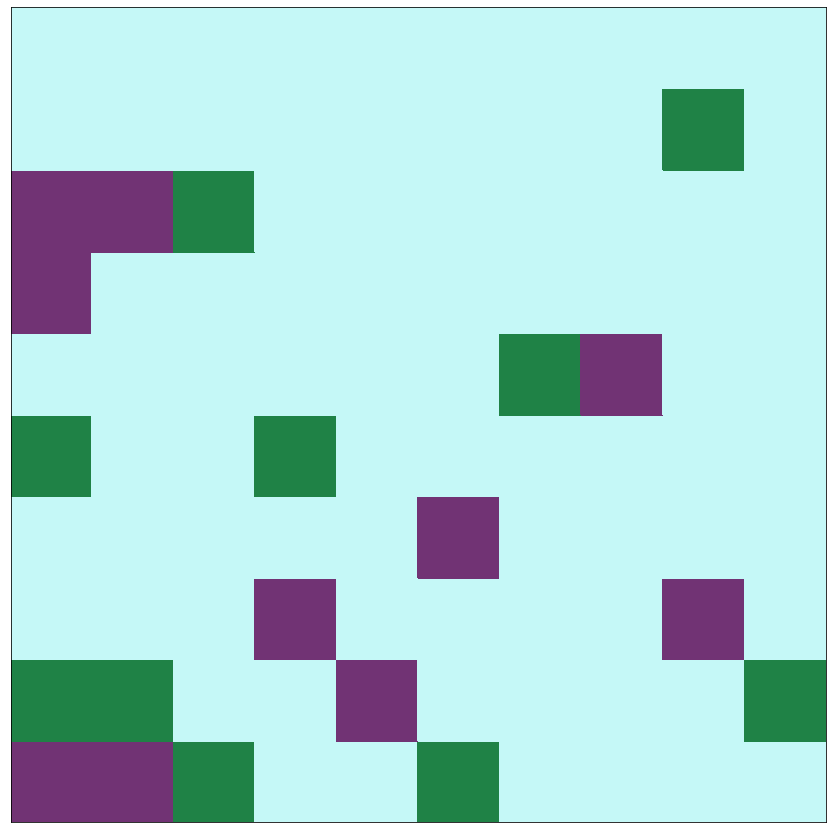

In [3]:
print(grid)
visualize_grid(grid)

The following function serve as an example on how monomers can be moved on a grid. As input, it takes the grid containing the positions of the monomers, a value specifying which monomer that is to be moved. The last argument is the direction the monomer is moved. If the monomer tries to move to a position already occupied by a different monomer, the move is prohibited, and the monomer remains in place. 

In [4]:
# We use the convention for directions: 0 = right, 1= left, 2=up, 3=down
# If we try to move monomers on top of a different monomer, nothing happens (This is an illegal move)
def move_monomer(grid, monomer_value, direction):
    # First we need to find the coordinates of the monomer we want to move
    # np.argwhere returns an array of all the coordinates that fulfill grid==monomer_value
    # Because there is only one grid point fulfilling grid==monomer_value, we extract the first element
    monomer_coordinates = np.argwhere(grid==monomer_value)[0] 

    N = grid.shape[0] # Finding the size of the grid
    # Now we find the coordiates of the neighboring grid point in the desired direction (using function from 1c)
    array_of_all_neighbor_coordinates = get_neighbors_coordinates(N=N, i=monomer_coordinates[0],
                                                                 j=monomer_coordinates[1])
    desired_neigbor_coordinate = array_of_all_neighbor_coordinates[direction]
    
    # Now we check if there is solvent (i.e. a zero) at the desired coordinate
    # meaning that we can move our monomer
    if grid[desired_neigbor_coordinate[0], desired_neigbor_coordinate[1]]==0:
        grid[desired_neigbor_coordinate[0], desired_neigbor_coordinate[1]] = monomer_value # moving the monomer
        grid[monomer_coordinates[0], monomer_coordinates[1]] = 0 #replacing old position of the monomer with solvent

       

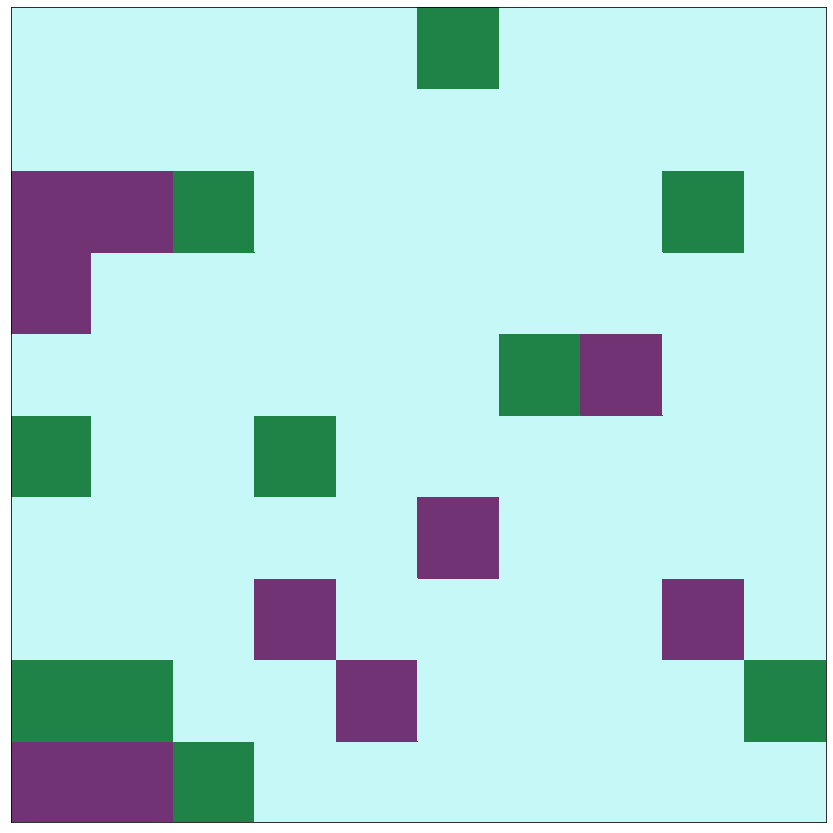

In [7]:
# Let's move the postively charged monomer in the center on the bottom row
# (marked by monomer_value=9) downwards (direction =3)
move_monomer(grid, monomer_value=10, direction=3)
visualize_grid(grid)

Note the effect of the periodic boundary conditions, as the monomer is moved to the top row.

In [8]:
#Let's make a dummy function that tries to move a random monomer in a random direction K times
def move_monomers_K_times(grid, K, M):
    for i in range(K):
        #Generates a random integer between 0 and 3 (low is inclusive, high is not)
        random_direction = np.random.randint(low=0, high=4) 
        # For generating a random monomer value, we generate the magntitude and sign seperately.
        magnitude = np.random.randint(1, M + 1)
        sign = 2 * np.random.randint(0, 2) - 1 # Easy way to generate random sign
        move_monomer(grid, sign*magnitude, random_direction)
        

# *numba* and *jit*

The Python library *numba* allows Python to reach speeds comparable to more low-level languages as C++ or Fortran, without any of the hassle often associated with these languages. The Python-syntax remains the same. 

To use *jit* (the main feature of *numa*), simply write

```
@jit(nopython = True)
```
in the line directly above a function. When the Python interpreter sees this command, it will compile the entire function. If this function is used many times, this means that Python uses the readily compiled function in stead of working line by line. This has the potential of saving a lot of time, and the beauty of *jit* is that it happens behind the scenes, you only need the simple command above. 

In this project, it will be beneficial to use *jit*, as it will allow you to study larger systems to a higher degree of accuracy. If you decide not to use *jit*, you will still be able to complete the project and get full marks, but your code will be slower, your results less reliable, and you will be limited to smaller systems. This is fine, but then I expect you to comment on the uncertainty in your results. 

Below is a simple example showing how *jit* works, and demonstrating the speedup one obtains by using it on the dummy function defined in the previous cell.

In [9]:
# Remove the # below to install numba if you do not have it already
#%pip install numba
from numba import jit
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

# Remove annoying deprecation warnings
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

In [10]:
#Lets's create numba versions of the same functions
@jit(nopython=True)
def move_monomer_fast(grid, monomer_value, direction):
    monomer_coordinates = np.argwhere(grid==monomer_value)[0] 
    
    N = grid.shape[0]
    array_of_all_neighbor_coordinates = get_neighbors_coordinates(N=N, i=monomer_coordinates[0],
                                                                 j=monomer_coordinates[1])
    desired_neigbor_coordinate = array_of_all_neighbor_coordinates[direction]

    if grid[desired_neigbor_coordinate[0], desired_neigbor_coordinate[1]]==0:
        grid[desired_neigbor_coordinate[0], desired_neigbor_coordinate[1]] = monomer_value
        grid[monomer_coordinates[0], monomer_coordinates[1]] = 0
        
@jit(nopython=True)
def move_monomers_K_times_fast(grid, K, M):
    for i in range(K):
        random_direction = np.random.randint(low=0, high=4) 
        magnitude = np.random.randint(1, M + 1)
        sign = 2 * np.random.randint(0, 2) - 1 
        move_monomer_fast(grid, sign*magnitude, random_direction)


In [11]:
K=10000
N = 10
M = 10
test_grid = generate_grid_of_monomers(N, M)
%timeit move_monomers_K_times(test_grid, K=K, M=M)

243 ms ± 9.45 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
K=10000
N = 10
M = 10
test_grid = generate_grid_of_monomers(N, M)
%timeit move_monomers_K_times_fast(test_grid, K=K, M=M)

11.9 ms ± 111 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


The jitted functions roughly 20 times faster, not bad! This speedup increases even further once you start to have more complex functions than the simple one presented here. 

## *jit* pitfalls
* All function calls in a jitted function must also be jitted. 
* *jit* works fine with numpy, but it does not work with *matplotlib*, so never plot in a function that is jitted.
* Do not use empty lists, always specify how large your arrays are.
* Specify the type of your arrays. This is especially important when you want the *grid* variable to only contain integers. Specifying that your array contains integers can be done in the following way ```grid = np.zeros((N, N), dtype=np.dtype('i2'))```, where the last argument specifies that the variables in *grid* are 2-byte integers.
* If you want to make a copy of an array or grid, use the following syntax ```new_grid = grid.copy()```
* Functions that have been "jitted" will give confusing error messages. Thus, to debug your code efficiently, it is a good idea to develop a fully functioning framework before you jit all the necessary functions. The error messages from ordinary Python are far easier to understand. 

# General tips

* Write structured code (easier said than done, I know) with informative variable names. Include comments in your code. This will help you understand and evaluate your own code and help me understand your code. 
* Save data and figures as you work (np.savez and plt.savefig are useful for this).
* Develop your code at low numerical accuracy. Once you are sure the code works as it should, only then start to increase the number of MC steps. 
* Depending on your code, you may have calculations with a lot of runtime. Even though you will not be evaluated on how fast your code is, you will get more interesting and accurate results if you increase the number of MC steps. To speed up your code, always use *numpy* when possible. *numpy* is fast, and works seamlessly with *numba*. In addition, the task of running different Monte Carlo simulations (e.g. at different temperatures) is a task that it so-called *embarrassingly parallel*. This means that it is relatively easy to run simulations at different CPU cores. However, don't let the term fool you. In practice, it may be quite hard to get the parallelization to work properly. I stress that this is **absolutely not** a requirement for the project, but for those of you that are interested, I recommend the python library *dask* as it is a relatively user friendly parallelization library.
* Your teaching assistants are not experts in neither *numba* nor *dask*, so you cannot expect them to fix all problems relating to these libraries. 
* *np.random.random()* is a a simple command that generates a random decimal number between 0 and 1. 
* Lastly, I want to highlight two *numpy* functions you will useful. Firstly, *np.argwhere* will be useful throughout the project.  ```np.argwhere(grid)``` returns an array of all the positions of the non-zero values of the *grid* (i.e. all the monomer coordinates). As we showed earlier in this notebook, you can also specify which monomer(s) you look for by using ```np.argwhere(grid==monomer_value)```.  The second function you will find useful is *np.where()*. This will be of particular use in moving polymers in the second exercise. Look up the documentation for this function to understand how it works.